# 对比算法
* phantom routing
* 基于树结构的诱导路由技术
* 动态虚假源选择算法

In [1]:
from BaseSLPinCPS import *
import datetime

## 基于树结构的诱导路由技术

> Long J, Dong M, Ota K, et al. Achieving source location privacy and network lifetime maximization through tree-based diversionary routing in wireless sensor networks[J]. IEEE Access, 2014, 2: 633-651.

In [64]:
class routingTreeBranch(commonPM):
    """
    要求：Hwalk + PHI < SOURCE.level
    """
    def __init__(self, G = cpsNetwork(nodeNumber=10, areaLength=20, initEnergy=1e6, radius=50), \
                 Tmax=1000, Hwalk=30, Theta=np.random.rand(), PHI=10, C_Branch=0.65, \
                 sink_pos=(0,0), source_pos=(9, 9)):
        self.G = G
        
        self.Tmax = Tmax
        self.Hwalk = Hwalk
        self.Theta = Theta
        self.PHI = PHI
        self.C_Branch = C_Branch
        
        self.sink = -1
        self.sink_pos = sink_pos
        self.source = -1
        self.source_pos = source_pos
        
        self.attacker = cpsAttacker()
        
        self.safety = -1
        self.listDelay = []
        self.listEnergyConsumption = []
        
        self.path = []
        
    def display(self):
        print "节点总数 ", self.G.nodeNumber
        print "区域边长 ", self.G.areaLength
        print "节点初始能量 ", self.G.initEnergy
        print "节点最大通信半径 ", self.G.radius
        print "最大周期数 ", self.Tmax
        print "随机步数 ", self.Hwalk
        print "theta ", self.Theta
        print "PHI ", self.PHI
        print "sink ", self.sink, self.sink_pos
        print "source ", self.source, self.source_pos
        
    def generateSINKandSOURCE(self):
        """
        增加 sink 和 source，并更新邻接矩阵元素个数(+2)
        其中，
        sink 位于区域中心，(0,0)
        source 位于区域右上角 (0.45*areaLength, 0.45*areaLength)
        """
        self.sink = self.G.nodeNumber
        self.source = self.G.nodeNumber+1
        self.G.nodeList.append(cpsNode(identity=self.G.nodeNumber, \
                                       position=self.sink_pos, \
                                       energy=self.G.initEnergy*100., radius=self.G.radius, \
                                       state="SINK"))
        self.G.nodeList.append(cpsNode(identity=self.G.nodeNumber+1, \
                                       position=self.source_pos, \
                                       energy=self.G.initEnergy, radius=self.G.radius, \
                                       state="SOURCE"))
        self.G.adjacentMatrix = np.zeros((self.G.nodeNumber+2, self.G.nodeNumber+2), dtype=np.int8)
        self.G.nodeNumber += 2
    
    def deployAttacker(self, node):
        """
        部署攻击者初始位置，位于 sink
        """
        while self.attacker.trace:
            self.attacker.trace.pop()
        self.attacker.position = node
        self.attacker.trace.append(node.identity)
        
    def generateNetworkLevel(self):
        # print "构建网络层次"       
        queue = Queue.Queue()
        visited = np.zeros(self.G.nodeNumber, dtype=np.int8)
        
        self.G.nodeList[self.sink].level = 0
        queue.put(self.sink)
        visited[self.sink] = 1
        # 计算节点与基站之间最短的跳数
        while not queue.empty():
            u = queue.get()
            visited[u] = 0
            U = self.G.nodeList[u]
            for v in U.adj:
                V = self.G.nodeList[v]
                if V.level == -1 or U.level + 1 < V.level:
                    V.level = U.level + 1
                    if visited[v] == 0:
                        queue.put(v)
                        visited[v] = 1
    
    def pairDelayModel(self, U, V):
        """
        估计单跳，单位 bit 数据的时延
        """
        tuv = 100.       # 无干扰,bit,接收时间 ns
        pe = 0           # 环境的噪声功率
        guvl = 9.488e-5  # 无线设备参数，d < d0
        guvh = 5.0625    # 无线设备参数，d >= d0
        d0 = 231         # 跨空间距离阈值
        pt = 10e0        # 节点发送功率
        pv = 0           # 接收节点干扰功率
        puv = 0          # u->v 接收功率
        d = self.calculate2Distance(U, V)
        if d < d0:
            puv = (guvl*pt)/(d**2)
        else:
            puv = (guvh*pt)/(d**4)
        ruv = 0          # 信干噪比
        if pv > 1e-32:
            ruv = puv/(pe+pv)
        else:
            ruv = 20.
        # 范围单跳，单位 bit 时延
        return tuv/(1.-np.exp(ruv*(-0.5)))
    
    def searchDeepFirst(self, u, dist, former, target, bestPath):
        """
        深度优先搜索:(前驱节点，当前长度，已走过的路径，目标值，最佳路径)
        """
        # 加速收敛
        if dist > target:
            return target, bestPath
        
        U = self.G.nodeList[u]
        for v in U.adj:
            V = self.G.nodeList[v]
            if V.level >= U.level or v in former:
                continue
            dis = self.pairDelayModel(U, V)
            former.append(v)
            # 每到一次 sink，更新一次 target 值
            if v == self.sink:
                if dist+dis < target:
                    target = dist+dis
                    bestPath = former[:]
                else:
                    pass
                former.pop()  # 回溯
                return target, bestPath
            else:
                target, bestPath = self.searchDeepFirst(v, dist+dis, former, target, bestPath)
                former.pop()  # 回溯
        return target, bestPath
    
    def updateAdjMatrix(self):
        """
        算法的核心步骤：构建网路拓扑关系，即节点间的连接关系
        0) 生成网络层次
        1) 随机游走
        2) phantom node P -> intermediate node A
        3) phantom node P -> network border using "~director up"
        4) intermediate node A -> sink using shortest routing
        5) intermediate node A -> network border using "furthest up"
        6) node B in backbone ramdomly generates branch to network border using "closest lareger hops"
        给定：
        1) u is connected with v: G.adjacentMatrix[u, v] = 1
        2) u is not connected with v: G.adjacentMatrix[u, v] = 0
        拓扑更新方法如下：
        参考 Tree based routing 算法伪代码
        """
        #================生成网络层次====================# 0
        self.generateNetworkLevel()
        #================随机游走====================#    1
        # print "随机游走中..."： : source -> sin
        # director: 1->up, 0->down
        self.path.append(self.source)
        director = np.random.randint(low=0, high=2, dtype=np.int8)
        u = self.source
        v = -1
        for i in range(1, self.Hwalk+1):
            U = self.G.nodeList[u]
            vs = []
            for v in U.adj:
                V = self.G.nodeList[v]
                if director == 1 and V.level >= U.level:
                    vs.append(V.identity)
                elif director == 0 and V.level <= U.level:
                    vs.append(V.identity)
            if len(vs) == 0:
                #print '\nphantom:', u, U.level, vs
                break
            else:
                pass
            v = vs[np.random.randint(low=0, high=len(vs), dtype=np.int8)]
            self.path.append(v) # source -> P
            # 更新邻接矩阵
            self.G.adjacentMatrix[u, v] = 1
            self.G.adjacentMatrix[v, u] = 1
            u = v
        #================ P -> A ====================#   2
        # u 为 phantom node P
        nodeP = u
        self.G.nodeList[nodeP].state = 'P'
        if self.Theta > 1.0/2.0 + 1.0/self.Hwalk:
            director = 1 # 'right'
        else:
            director = 0 # 'left'
        # P -> A，getIntermediateNode(): source -> sink
        nextNode = nodeP
        PHI = self.PHI
        while PHI > 0:
            U = self.G.nodeList[nextNode]
            vs = []
            for v in U.adj:
                V = self.G.nodeList[v]
                if V.level < U.level:
                    if director == 1 and V.position[0] > U.position[0]: # 右下
                        vs.append(v)
                    elif director == 0 and V.position[0] < U.position[0]: # 左下
                        vs.append(v)
                    else:
                        pass
                else:
                    pass
            if len(vs) == 0:
                #print '\nintermediate:', nextNode, U.level, vs
                break
            else:
                pass
            v = vs[np.random.randint(low=0, high=len(vs), dtype=np.int8)]
            self.path.append(v) # P-> A
            # 更新邻接矩阵
            self.G.adjacentMatrix[nextNode, v] = 1
            self.G.adjacentMatrix[v, nextNode] = 1
            nextNode = v
            PHI -= 1
        # 到达节点 A
        nodeA = nextNode
        self.G.nodeList[nodeA].state = 'A'
        #================ P -> border ====================#   3
        nextNode = nodeP
        while True:
            U = self.G.nodeList[nextNode]
            larger = [x for x in U.adj \
                        if self.G.nodeList[x].level > U.level \
                          and sum(self.G.adjacentMatrix[x,:]) == 0]
            if len(larger) == 0:
                break
            else:
                pass
            vs = []
            for v in U.adj:
                if sum(self.G.adjacentMatrix[v,:]) != 0:
                    continue
                else:
                    pass
                V = self.G.nodeList[v]
                if V.level > U.level:
                    if director == 1 and V.position[0] < U.position[0]: # 左上
                        vs.append(v)
                    elif director == 0 and V.position[0] > U.position[0]: # 右上
                        vs.append(v)
                    else:
                        pass
                else:
                    pass
            if len(vs) == 0:
                #print '\nphantom to border:', nextNode, U.level, vs
                break
            else:
                pass
            v = vs[np.random.randint(low=0, high=len(vs), dtype=np.int8)]
            # 更新邻接矩阵
            self.G.adjacentMatrix[nextNode, v] = 1
            self.G.adjacentMatrix[v, nextNode] = 1
            nextNode = v
        # 计算骨干网络 backbone: 
        backbone = []
        #================ A -> sink ====================#   4
        # 1) A -> sink: : source -> sink
        target, bestPath = self.searchDeepFirst(nodeA, 0, [nodeA], 1e30, [])
        self.path.extend(bestPath[1:]) # source -> sink 路由构建完毕
        backbone.extend(bestPath)
        # 更新邻接矩阵
        u = bestPath[0]
        for v in bestPath[1:]:
            self.G.adjacentMatrix[u, v] = 1
            self.G.adjacentMatrix[v, u] = 1
            u = v
        #================ A -> border ====================#   5
        # 2) A -> border
        nextNode = nodeA
        while True:
            U = self.G.nodeList[nextNode]
            larger = [x for x in U.adj \
                        if self.G.nodeList[x].level > U.level and sum(self.G.adjacentMatrix[x,:]) == 0]
            if len(larger) == 0:
                break
            else:
                pass
            v = larger[0]
            for tv in larger[1:]:
                d1 = self.calculate2Distance(self.G.nodeList[v], self.G.nodeList[self.sink])
                d2 = self.calculate2Distance(self.G.nodeList[tv], self.G.nodeList[self.sink])
                if d1 < d2:
                    v = tv
                else:
                    pass
            # 更新邻接矩阵
            self.G.adjacentMatrix[nextNode, v] = 1
            self.G.adjacentMatrix[v, nextNode] = 1
            nextNode = v
            backbone.append(nextNode)
        #================ generate branch ====================#   6
        # 构建分支
        for v in backbone:
            # sink 位置与第一跳位置的骨干节点，不生成分支
            if self.G.nodeList[v].level <= 1:
                continue
            else:
                pass
            RAND = np.random.rand()
            # 随机方法确定该骨干节点是否生成分支
            if RAND < self.C_Branch:
                # 骨干节点 v -> border
                nextNode = v
                while True:
                    U = self.G.nodeList[nextNode]
                    d1 = self.calculate2Distance(U, self.G.nodeList[v]) # 分支方向
                    d2 = self.calculate2Distance(U, self.G.nodeList[self.sink])
                    larger = [x for x in U.adj \
                                if self.G.nodeList[x].level >= U.level \
                                and sum(self.G.adjacentMatrix[x,:]) == 0 \
                                and d1 < self.calculate2Distance(self.G.nodeList[x], self.G.nodeList[v]) \
                                and d2 < self.calculate2Distance(self.G.nodeList[x], self.G.nodeList[self.sink])]
                    if len(larger) == 0:
                        break
                    else:
                        pass
                    tv = larger[np.random.randint(low=0, high=len(larger), dtype=np.int8)]
                    # 更新邻接矩阵
                    self.G.adjacentMatrix[nextNode, tv] = 1
                    self.G.adjacentMatrix[tv, nextNode] = 1
                    nextNode = tv
    
    def delayModelusingAdjMatrix(self, G, u, v):
        """
        估计单个节点，单跳，单位 bit 数据的时延
        u -> v
        """
        tuv = 100.       # 无干扰,bit,接收时间 ns
        pe = 0           # 环境的噪声功率
        guvl = 9.488e-5  # 无线设备参数，d < d0
        guvh = 5.0625    # 无线设备参数，d >= d0
        d0 = 231         # 跨空间距离阈值
        pt = 10e0        # 节点发送功率
        U = G.nodeList[u]
        V = G.nodeList[v]
        pv = 0           # 接收节点干扰功率
        for neighbor in V.adj:
            Neighbor = G.nodeList[neighbor]
            # 使用 .adjacentMatrix 判定两节点是否连通
            if (G.adjacentMatrix[neighbor, v] == 1 or G.adjacentMatrix[v, neighbor] == 1) \
                and (neighbor != u):
                d = self.calculate2Distance(Neighbor, V)
                if d < d0:
                    puv = (guvl*pt)/(d**2)
                else:
                    puv = (guvh*pt)/(d**4)
                pv += puv
        puv = 0          # u->v 接收功率
        d = self.calculate2Distance(U, V)
        if d < d0:
            puv = (guvl*pt)/(d**2)
        else:
            puv = (guvh*pt)/(d**4)
        ruv = 0          # 信干噪比
        if pv > 1e-32:
            ruv = puv/(pe+pv)
        else:
            ruv = 20.
        # 范围单跳，单位 bit 时延
        return tuv/(1.-np.exp(ruv*(-0.5)))
    
    def sendSource2Sink(self, Ti):
        """
        一个周期内容事件：
        1）主要事件：源节点（包含分支上的虚假源）发送消息，并通过路径传输至基站
        输入参数：
        1）网络的链接矩阵 G.adjacentMatrix
        更新的参数：
        1）节点剩余能量
        2）攻击者位置
        返回值：
        1）源节点是否被捕获
        2）源节点消息上传到基站的时间花费
        3）网络能耗
        """
        packetSize = 500*8  # 单次数据包大小 bit
        # 路由时延 and 网络能耗
        delayTi = 0
        energyTi = 0
        u = -1
        for i,v in enumerate(self.path):
            if i == 0:
                u = v
            else:
                delayTi += self.delayModelusingAdjMatrix(self.G, u, v)*packetSize
                u = v
        ids = np.arange(self.G.nodeNumber)
        energyNodes = set(ids[self.G.adjacentMatrix.sum(axis=1)>0])|set(ids[self.G.adjacentMatrix.sum(axis=0)>0])
        for v in energyNodes:
            V = self.G.nodeList[v]
            ec = self.energyModel(self.G, V)*packetSize
            self.G.nodeList[V.identity].energy -= ec
            energyTi += ec
        # 攻击者移动
        self.attacker.tracebackUsingAdjMatrix(self.G)
        # 源节点是否被捕获
        flag = False
        if self.attacker.position.identity == self.source:
            flag = True
        else:
            flag = False
        return flag, delayTi, energyTi
    
    def algTreeBranchRouting(self):
        """
        Tree Branch Routing 过程
        """
        listDelay = []
        listEnergyConsumption = []
        safety = -1
        for Ti in range(1, self.Tmax+1):
            if Ti % 100 == 0:
                print Ti
            else:
                print Ti,
#             start = datetime.datetime.now()
            if Ti % 1 == 0:
                self.G.adjacentMatrix = np.zeros((self.G.nodeNumber, self.G.nodeNumber), dtype=np.int8)
                self.path = []
                self.updateAdjMatrix()
            # 源节点发送消息给基站的事件
            flag, delayTi, energyTi = self.sendSource2Sink(Ti)
            # 保存每轮的记录
            listDelay.append(delayTi)
            listEnergyConsumption.append(energyTi)
#             end = datetime.datetime.now()
#             print '\nIt costs', end-start
            if flag:
                safety = Ti
                break
            elif Ti == self.Tmax:
                safety = self.Tmax
            else:
                pass
        return safety, listDelay, listEnergyConsumption
    
    def treebranchRouting(self):
        """
        Tree Branch Routing 主函数
        1）生成 sink 和 source
        2）网络连通性判定，直至网络连通（当网络每判定连通时）
        3）tree branch routing 及事件模拟
        其中，
        1）时延，单位 ns,纳秒
        2）能耗，单位 nj,纳焦
        """
        self.generateSINKandSOURCE()
        if len(self.G.nodeList[self.sink].adj) == 0:
            flag = self.isConnected(self.G, self.sink) # 更新各节点邻居
            if not flag:
                print "网络不连通"
                return
            else:
                print "网络连通"
        else:
            pass
        self.deployAttacker(self.G.nodeList[self.sink]) # 部署攻击者位置
        self.safety, self.listDelay, self.listEnergyConsumption = self.algTreeBranchRouting()
        print "\nThe safety is %d" % self.safety

In [65]:
############################### 开始调试 ##########################################
tb = routingTreeBranch(G=cpsNetwork(nodeNumber=1000, areaLength=20, initEnergy=1e8, radius=1.5), \
                 Tmax=20, Hwalk=2, Theta=0.2, PHI=2, C_Branch=0.65, \
                 sink_pos=(-0.4*20,-0.4*20), source_pos=(0.4*15, 0.4*15))
tb.display()

节点总数  1000
区域边长  20
节点初始能量  100000000.0
节点最大通信半径  1.5
最大周期数  20
随机步数  2
theta  0.2
PHI  2
sink  -1 (-8.0, -8.0)
source  -1 (6.0, 6.0)


In [66]:
tb.treebranchRouting()

网络连通性判定...
网络连通
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
The safety is 20


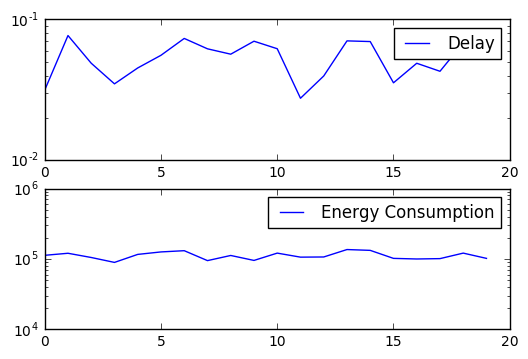

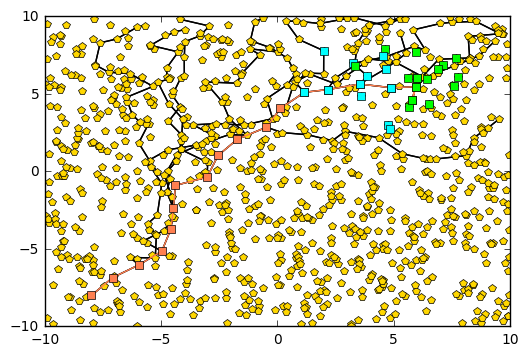

In [79]:
plt.subplot(211)
plt.semilogy(np.array(tb.listDelay)/1e9)
plt.legend(['Delay'])
plt.subplot(212)
plt.semilogy(np.array(tb.listEnergyConsumption)/tb.G.nodeNumber)
plt.legend(['Energy Consumption'])
plt.show()

plt.figure()
for u in range(tb.G.nodeNumber):
    U = tb.G.nodeList[u]
    for v in U.adj:
        V = tb.G.nodeList[v]
        if tb.G.adjacentMatrix[u, v] == 1:
            x = [U.position[0], V.position[0]]
            y = [U.position[1], V.position[1]]
            plt.plot(x, y, 'k')
            
temp_x = []
temp_y = []
for i in range(tb.G.nodeNumber):
    if i in tb.path:
        continue
    temp_x.append(tb.G.nodeList[i].position[0])
    temp_y.append(tb.G.nodeList[i].position[1])
plt.plot(temp_x, temp_y, linewidth = 0, color='gold', marker='p')

temp_x = []
temp_y = []
for i in tb.path:
    temp_x.append(tb.G.nodeList[i].position[0])
    temp_y.append(tb.G.nodeList[i].position[1])
plt.plot(temp_x, temp_y, color='coral', marker='s')

for i in range(tb.G.nodeNumber):
    V = tb.G.nodeList[i]
    if V.state == 'P':
        plt.plot([V.position[0]], [V.position[1]], color='lime', marker='s')
    elif V.state == 'A':
        plt.plot([V.position[0]], [V.position[1]], color='cyan', marker='s')

plt.show()

In [70]:
print tb.path

[1001, 729, 565, 288, 655, 961, 274, 345, 621, 278, 400, 225, 805, 500, 850, 936, 390, 96, 1000]


In [54]:
tb.display()

节点总数  1002
区域边长  20
节点初始能量  100000000.0
节点最大通信半径  1.5
最大周期数  100
随机步数  2
theta  0.2
PHI  2
sink  1000 (-8.0, -8.0)
source  1001 (6.0, 6.0)
